# This notebook shows implementation of a simple classification of IMDB reviews using logistic regression

This dataset is avilable on kaggle: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import nltk
import nltk.tokenize
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from wordcloud import WordCloud,STOPWORDS   # pip install wordcloud
from bs4 import BeautifulSoup
from textblob import TextBlob   # pip install textblob
from textblob import Word

In [2]:
np.random.seed(42)

## Load and prepare IMDB data

In [3]:
imdb = pd.read_csv('./imdb/IMDB_reviews.csv')
imdb.shape

(50000, 2)

In [4]:
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
imdb.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [6]:
imdb['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [22]:
input_dt = imdb['review']
output_var = imdb['sentiment']

#### Prepare the data for classification (bag of words)

In [23]:
def convert_to_lower(review):
    return review.lower()

input_dt=input_dt.apply(convert_to_lower)
input_dt.head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production. <br /><br />the...
2    i thought this was a wonderful way to spend ti...
3    basically there's a family where a little boy ...
4    petter mattei's "love in the time of money" is...
Name: review, dtype: object

In [26]:
def strip_html(review):
    soup = BeautifulSoup(review, "html.parser")
    return soup.get_text()

input_dt=input_dt.apply(strip_html)
input_dt.head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production. the filming tec...
2    i thought this was a wonderful way to spend ti...
3    basically there's a family where a little boy ...
4    petter mattei's "love in the time of money" is...
Name: review, dtype: object

In [27]:
def denoise_text(review):
    review = strip_html(review)
    return re.sub('\[[^]]*\]', '', review)

input_dt=input_dt.apply(denoise_text)
input_dt.head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production. the filming tec...
2    i thought this was a wonderful way to spend ti...
3    basically there's a family where a little boy ...
4    petter mattei's "love in the time of money" is...
Name: review, dtype: object

In [28]:
def remove_special_characters(review):
    pattern=r'[^a-zA-z0-9\s]'
    return re.sub(pattern,'',review)

input_dt=input_dt.apply(remove_special_characters)
input_dt.head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically theres a family where a little boy j...
4    petter matteis love in the time of money is a ...
Name: review, dtype: object

In [29]:
def tokenize_reviews(review):
    return word_tokenize(review)

input_dt=input_dt.apply(tokenize_reviews)
input_dt.head()

0    [one, of, the, other, reviewers, has, mentione...
1    [a, wonderful, little, production, the, filmin...
2    [i, thought, this, was, a, wonderful, way, to,...
3    [basically, theres, a, family, where, a, littl...
4    [petter, matteis, love, in, the, time, of, mon...
Name: review, dtype: object

In [30]:
stop_words=nltk.corpus.stopwords.words('english')

def remove_stop_words(review):
    return [w for w in review if not w in stop_words]
    
input_dt=input_dt.apply(remove_stop_words)
input_dt.head()

0    [one, reviewers, mentioned, watching, 1, oz, e...
1    [wonderful, little, production, filming, techn...
2    [thought, wonderful, way, spend, time, hot, su...
3    [basically, theres, family, little, boy, jake,...
4    [petter, matteis, love, time, money, visually,...
Name: review, dtype: object

In [31]:
stemmer = PorterStemmer()

def stem_words(review):
    return [stemmer.stem(w) for w in review]

#stem input review data
input_dt=input_dt.apply(stem_words)
input_dt.head()

0    [one, review, mention, watch, 1, oz, episod, y...
1    [wonder, littl, product, film, techniqu, unass...
2    [thought, wonder, way, spend, time, hot, summe...
3    [basic, there, famili, littl, boy, jake, think...
4    [petter, mattei, love, time, money, visual, st...
Name: review, dtype: object

In [32]:
lemmatizer = WordNetLemmatizer()

def lemmatize_verbs(review):
    return [lemmatizer.lemmatize(w, pos = wordnet.VERB) for w in review]

input_dt=input_dt.apply(lemmatize_verbs)
input_dt.head()

0    [one, review, mention, watch, 1, oz, episod, y...
1    [wonder, littl, product, film, techniqu, unass...
2    [think, wonder, way, spend, time, hot, summer,...
3    [basic, there, famili, littl, boy, jake, think...
4    [petter, mattei, love, time, money, visual, st...
Name: review, dtype: object

In [33]:
def lemmatize_nouns(review):
    return [lemmatizer.lemmatize(w, pos = wordnet.NOUN) for w in review]

input_dt=input_dt.apply(lemmatize_nouns)
input_dt.head()

0    [one, review, mention, watch, 1, oz, episod, y...
1    [wonder, littl, product, film, techniqu, unass...
2    [think, wonder, way, spend, time, hot, summer,...
3    [basic, there, famili, littl, boy, jake, think...
4    [petter, mattei, love, time, money, visual, st...
Name: review, dtype: object

In [34]:
def join_words(review):
    return " ".join(review)

input_dt=input_dt.apply(join_words)
input_dt.head()

0    one review mention watch 1 oz episod youll hoo...
1    wonder littl product film techniqu unassum old...
2    think wonder way spend time hot summer weekend...
3    basic there famili littl boy jake think there ...
4    petter mattei love time money visual stun film...
Name: review, dtype: object

In [35]:
#design vocabulary
tfidf_vectorizer = TfidfVectorizer()

#create vectorized representation
bag_of_words = tfidf_vectorizer.fit_transform(input_dt)

features = tfidf_vectorizer.get_feature_names()

In [36]:
Y = imdb['sentiment']
X_bow = pd.DataFrame(bag_of_words.toarray(), columns = features)
X_bow.shape

(50000, 180959)

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X_bow, Y, test_size=0.2, random_state=0)

#### Word cloud visualization

<function matplotlib.pyplot.show(*args, **kw)>

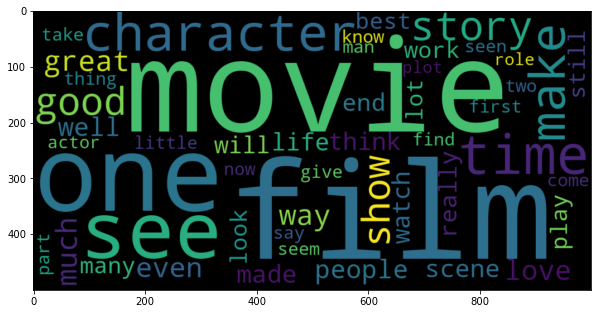

In [37]:
positive_reviews = imdb.loc[imdb['sentiment'] == "positive", 'review']
positive_reviews = positive_reviews.apply(strip_html)
positive_reviews = positive_reviews.apply(denoise_text)
positive_reviews = positive_reviews.apply(remove_special_characters)
positive_reviews_text = " ".join(positive_reviews)

plt.figure(figsize=(10,10))
WC=WordCloud(width=1000,height=500,max_words=50,min_font_size=5)
positive_words=WC.generate(positive_reviews_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

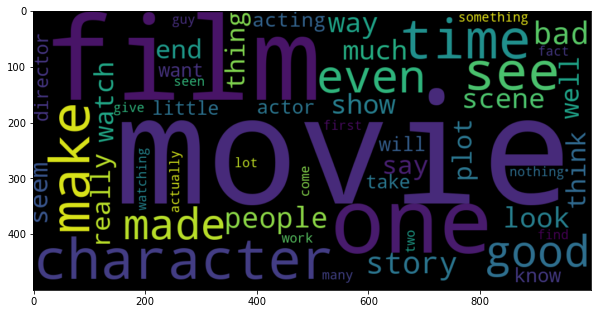

In [38]:
positive_reviews = imdb.loc[imdb['sentiment'] == "negative", 'review']
positive_reviews = positive_reviews.apply(strip_html)
positive_reviews = positive_reviews.apply(denoise_text)
positive_reviews = positive_reviews.apply(remove_special_characters)
positive_reviews_text = " ".join(positive_reviews)

plt.figure(figsize=(10,10))
WC=WordCloud(width=1000,height=500,max_words=50,min_font_size=5)
positive_words=WC.generate(positive_reviews_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

#### Build a logistic regression model and visualize results on the test set

In [22]:
model = LogisticRegression(penalty="l2").fit(X_train, Y_train)

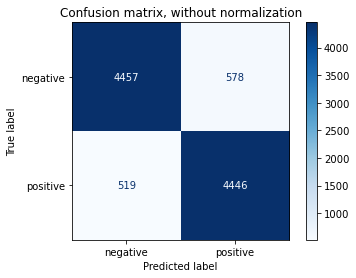

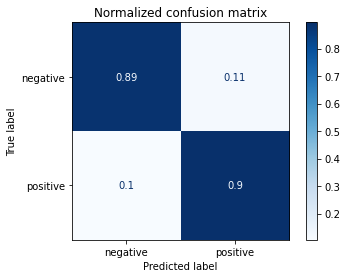

In [23]:
# this code is adopted from this example:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, Y_test,
                                 display_labels=['negative', 'positive'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()